# Introductory Example

This demonstrates an example using scalecast `0.17.6`. Several features explored are not available in earlier versions, so if anything is not working, try upgrading:

`pip install --upgrade scalecast`

If things are still not working, you spot a typo, or you have some other suggestion to improve functionality or document readability, open an [issue](https://github.com/mikekeith52/scalecast/issues/new) or email mikekeith52@gmail.com.

Link to dataset used in this example: https://www.kaggle.com/datasets/neuromusic/avocado-prices.  

Latest [official documentation](https://scalecast.readthedocs.io/en/latest/index.html).  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in data
data = pd.read_csv('avocado.csv',parse_dates = ['Date'])
data = data.sort_values(['region','type','Date'])

[Univariate Forecasting](#Univariate-Forecasting)  
[Multivariate Forecasting](#Multivariate-Forecasting)  
[Transformations](#Transformations)  
[Pipelines](#Pipelines)  
[Fully Automated Pipelines](#Fully-Automated-Pipelines)  
[Scaled Automated Forecasting](#Scaled-Automated-Forecasting)  
[Exporting Results](#Exporting-Results)  

## Univariate Forecasting

### Load the `Forecaster` Object
- This is an object that can store data, run forecasts, store results, and plot. It's a UI, procedure, and set of models all-in-one.
- Forecasts in scalecast are run with a dynamic recursive approach by default, as opposed to a direct or other approach.
- [Forecaster Object Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html).

In [3]:
from scalecast.Forecaster import Forecaster

In [4]:
volume = data.groupby('Date')['Total Volume'].sum()

In [5]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = 13,
)

f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Exploratory Data Analysis

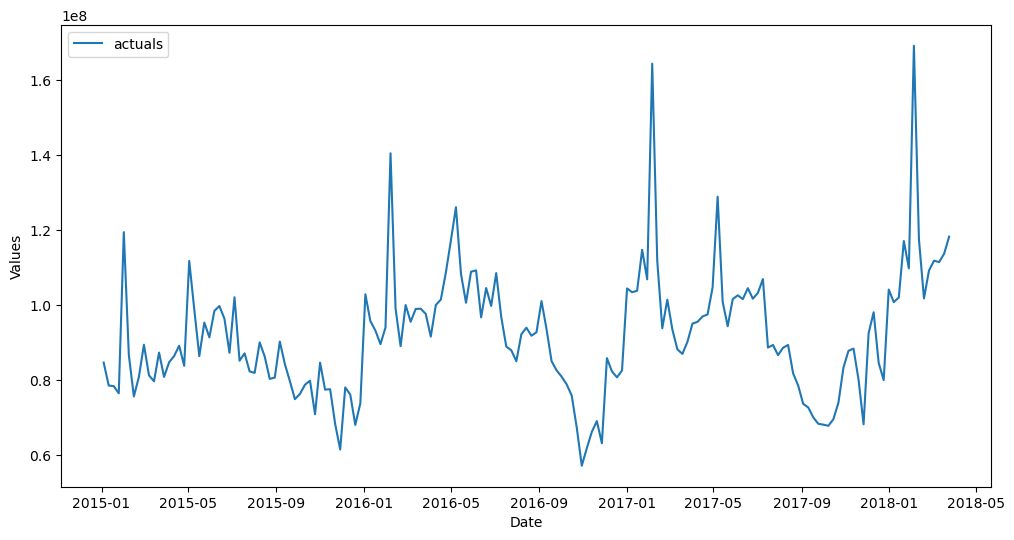

In [6]:
f.plot()
plt.show()

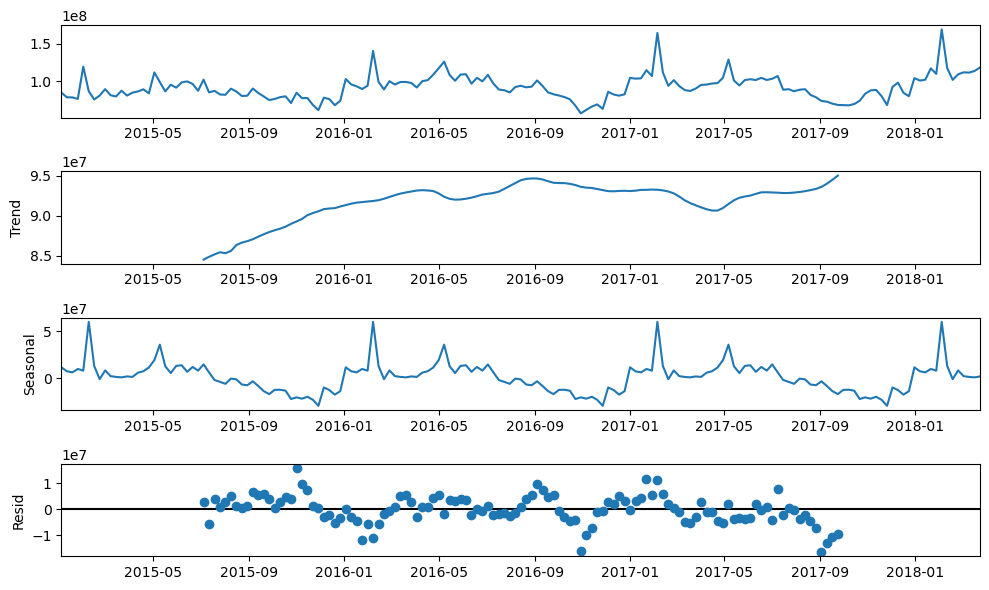

In [7]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

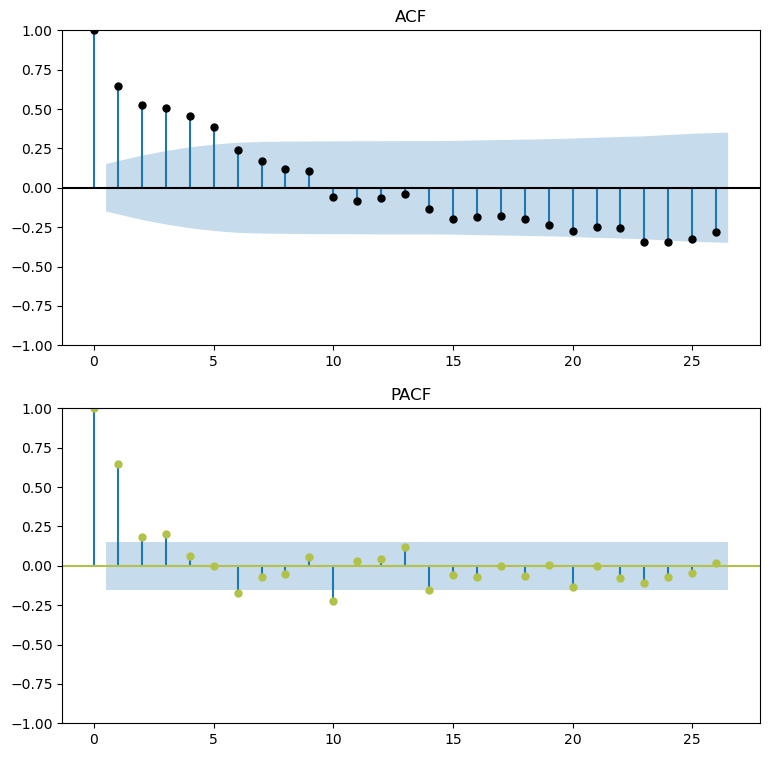

In [8]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF',lags=26,color='black')
f.plot_pacf(ax=axs[1],title='PACF',lags=26,color='#B2C248',method='ywm')
plt.show()

### Parameterize the `Forecaster` Object

#### Set Test Length
- Starting in scalecast version 0.16.0, you can skip model testing by setting a test length of 0.
- In this example, all models will be tested on the last 15% of the observed values in the dataset.

In [9]:
f.set_test_length(.15)

#### Tell the Object to Evaluate Confidence Intervals
- This only works if there is a test set specified and it is of a sufficient size.
- See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.eval_cis).
- See the [example](https://scalecast-examples.readthedocs.io/en/latest/misc/cis/cis.html).

In [10]:
# default args below
f.eval_cis(
    mode = True, # tell the object to evaluate intervals
    cilevel = .95, # 95% confidence level
)

#### Specify Model Inputs

##### Trend

In [11]:
f.add_time_trend()

##### Seasonality

In [12]:
f.add_seasonal_regressors('week',raw=False,sincos=True)

##### Autoregressive Terms / Series Lags

In [13]:
f.add_ar_terms(13)

In [14]:
f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13']
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Run Models
- See the [available models](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html).
- See the [blog post](https://medium.com/towards-data-science/expand-your-time-series-arsenal-with-these-models-10c807d37558).
- The `dynamic_testing` argument for all of these will be 13 -- test-set results will then be in terms of rolling averages of 13-step forecasts, which is also our forecast length.

#### Linear Scikit-Learn Models

In [15]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=13)

In [16]:
f.set_estimator('lasso')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

In [17]:
f.set_estimator('ridge')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

In [18]:
f.set_estimator('elasticnet')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

In [19]:
f.set_estimator('sgd')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

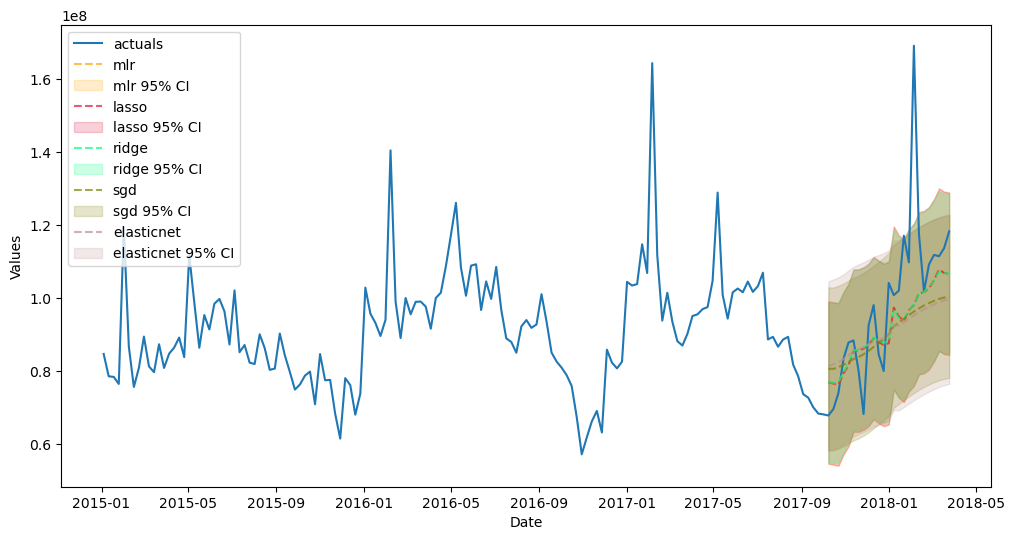

In [20]:
f.plot_test_set(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='LevelTestSetMAPE')
plt.show()

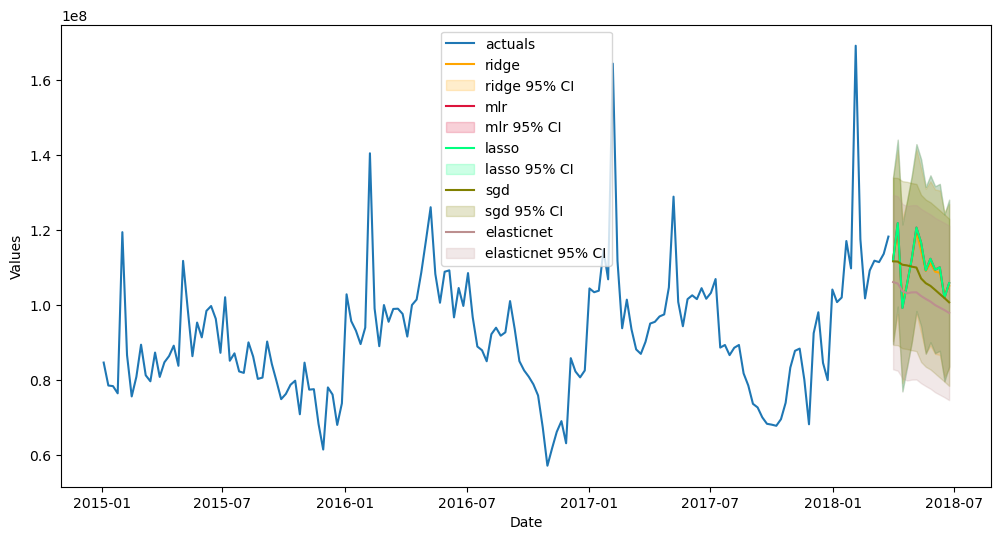

In [21]:
f.plot(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='TestSetRMSE')
plt.show()

#### Non-linear Scikit-Learn Models

In [22]:
f.set_estimator('rf')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [23]:
f.set_estimator('gbt')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [24]:
f.set_estimator('xgboost')
f.manual_forecast(gamma=1,dynamic_testing=13)

In [25]:
f.set_estimator('lightgbm')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [26]:
f.set_estimator('catboost')
f.manual_forecast(depth=4,verbose=False,dynamic_testing=13)

In [27]:
f.set_estimator('knn')
f.manual_forecast(n_neighbors=5,dynamic_testing=13)

In [28]:
f.set_estimator('mlp')
f.manual_forecast(hidden_layer_sizes=(50,50),solver='lbfgs',dynamic_testing=13)

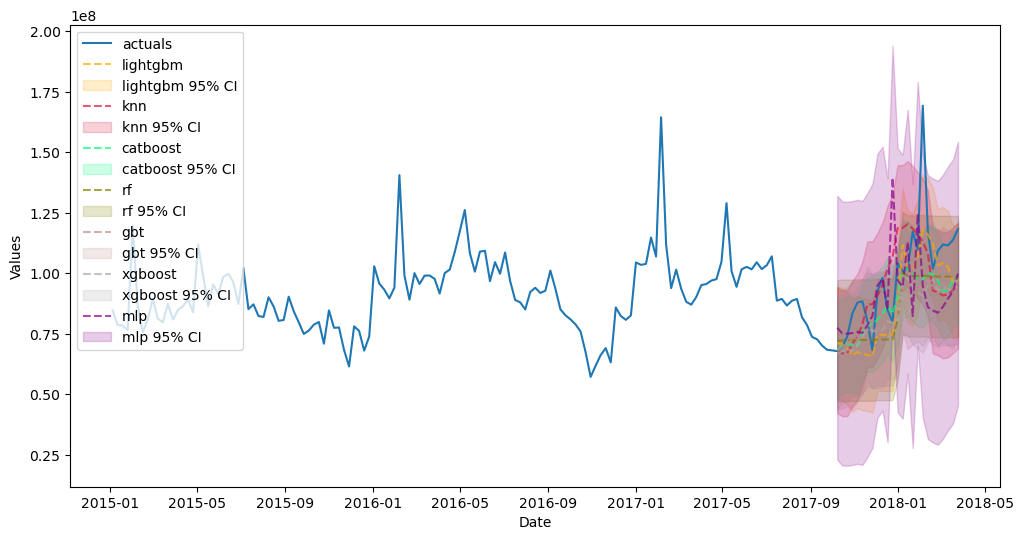

In [29]:
f.plot_test_set(
    ci=True,
    models=['rf','gbt','xgboost','lightgbm','catboost','knn','mlp'],
    order_by='TestSetRMSE'
)
plt.show()

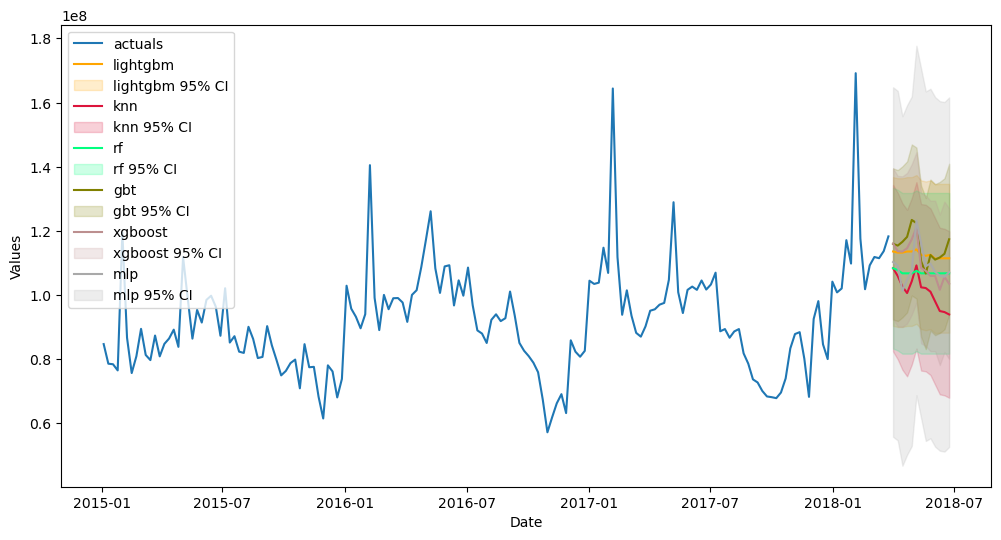

In [30]:
f.plot(ci=True,models=['rf','gbt','xgboost','lightgbm','knn','mlp'],order_by='TestSetRMSE')
plt.show()

#### Stacking Models

##### Custom Stacking Model

In [31]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [32]:
f.add_sklearn_estimator(StackingRegressor,'stacking')

In [33]:
estimators = [
    ('elasticnet',ElasticNet(alpha=0.2)),
    ('xgboost',XGBRegressor(gamma=1)),
    ('gbt',GradientBoostingRegressor(max_depth=2)),
]

final_estimator = LGBMRegressor()

f.set_estimator('stacking')
f.manual_forecast(
    estimators=estimators,
    final_estimator=final_estimator,
    dynamic_testing=13
)

##### MLP Stack from scalecast
- [auxmodels.mlp_stack](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#module-src.scalecast.auxmodels.mlp_stack)

In [34]:
from scalecast.auxmodels import mlp_stack

In [35]:
mlp_stack(f,model_nicknames=['elasticnet','lightgbm','xgboost','knn'],dynamic_testing=13)

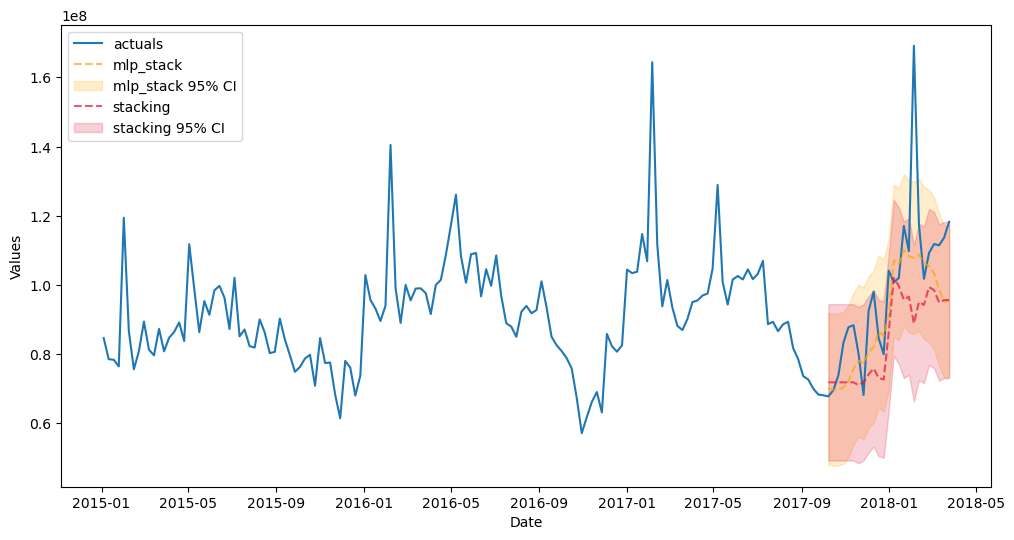

In [36]:
f.plot_test_set(models=['stacking','mlp_stack'],ci=True,order_by='TestSetRMSE')
plt.show()

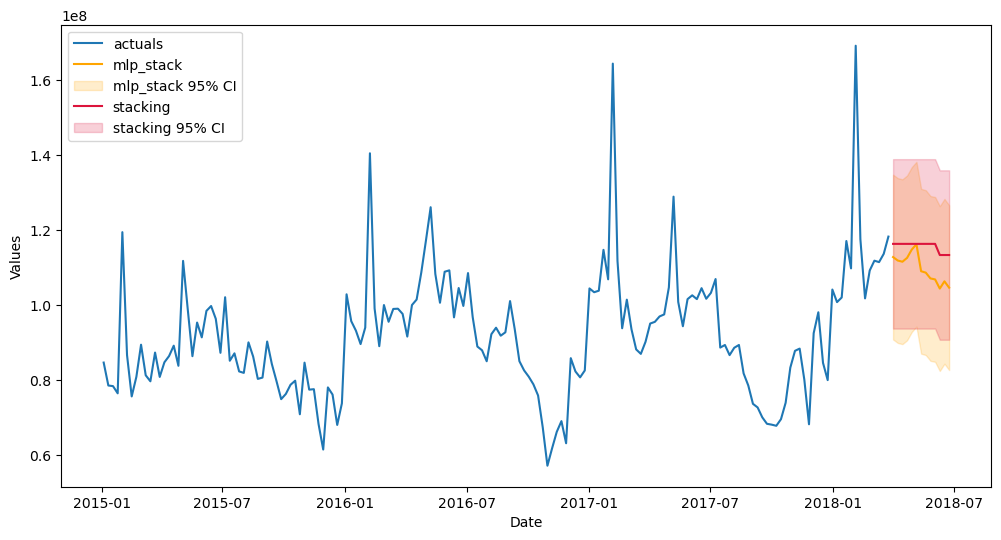

In [37]:
f.plot(models=['stacking','mlp_stack'],ci=True,order_by='TestSetRMSE')
plt.show()

#### ARIMA
- [auxmodels.auto_arima](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#module-src.scalecast.auxmodels.auto_arima)

In [38]:
from scalecast.auxmodels import auto_arima

In [39]:
auto_arima(f,m=52)

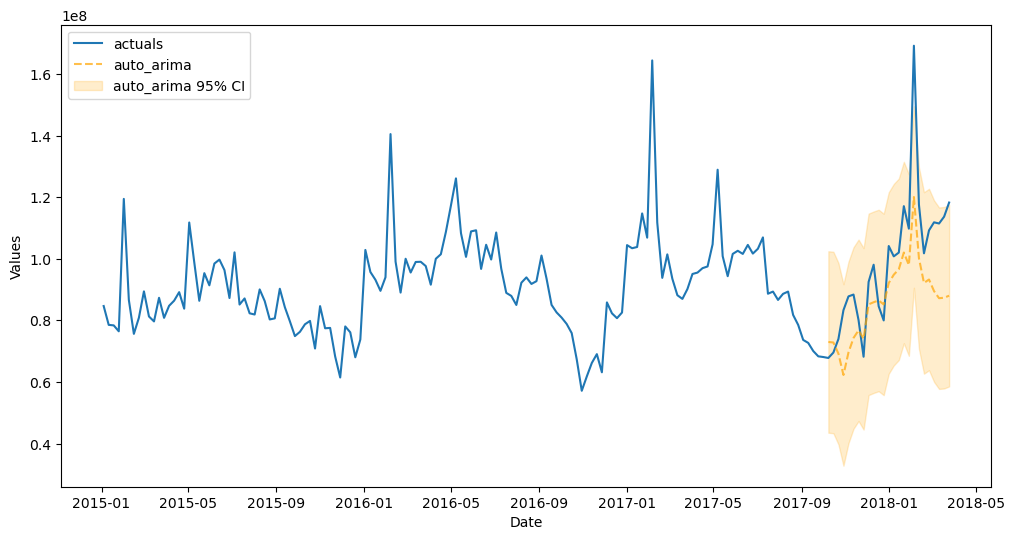

In [40]:
f.plot_test_set(models='auto_arima',ci=True)
plt.show()

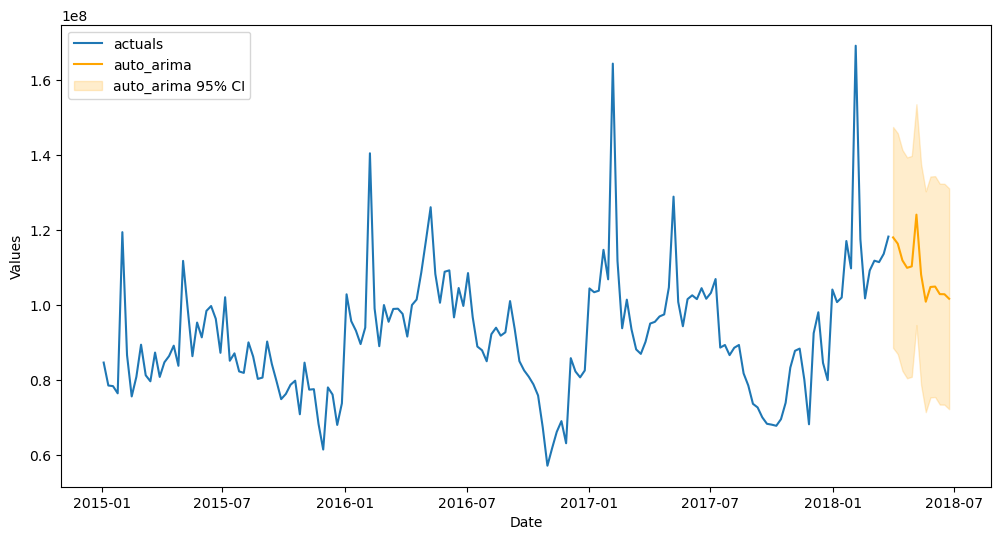

In [41]:
f.plot(models='auto_arima',ci=True)
plt.show()

#### Prophet

In [42]:
f.set_estimator('prophet')
f.manual_forecast()

14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:46 - cmdstanpy - INFO - Chain [1] done processing
14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:46 - cmdstanpy - INFO - Chain [1] done processing


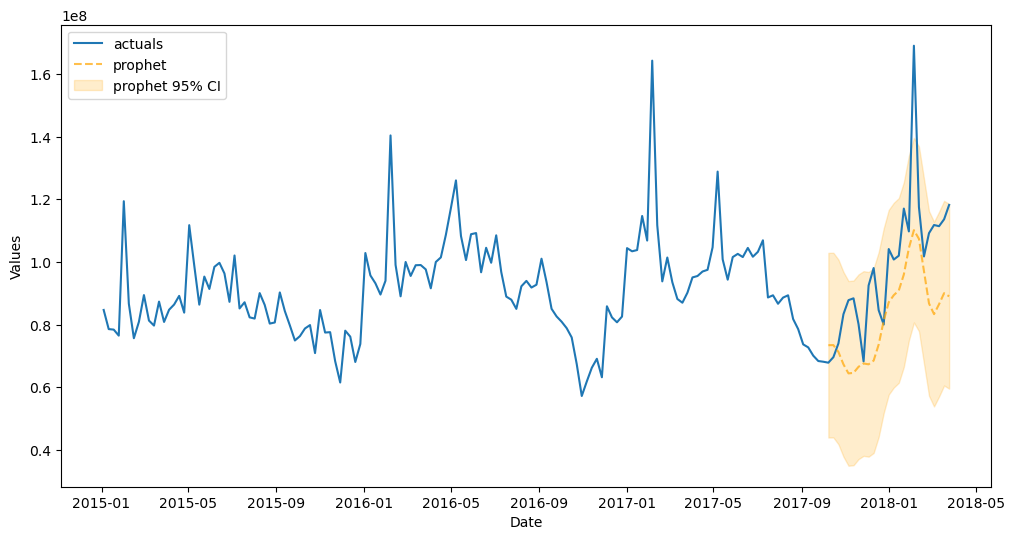

In [43]:
f.plot_test_set(models='prophet',ci=True)
plt.show()

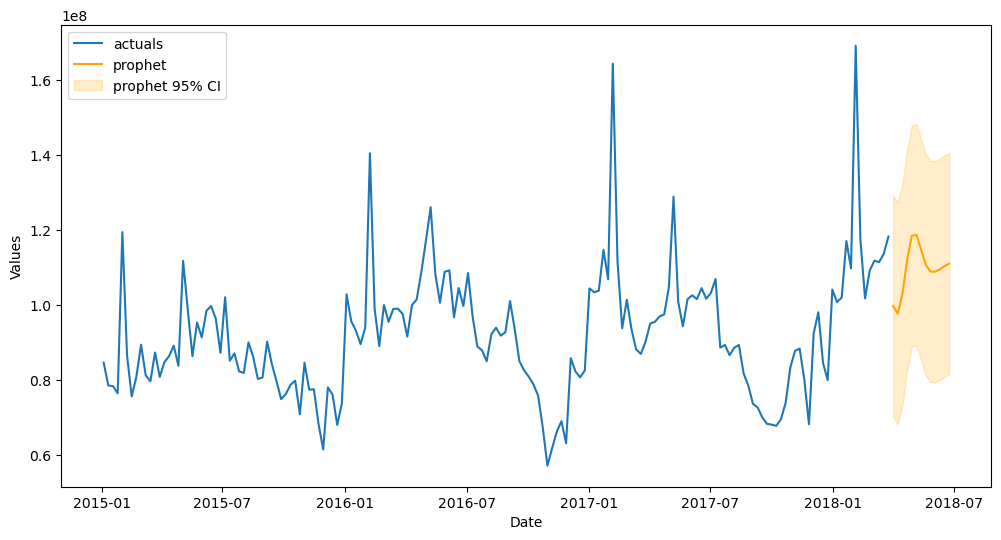

In [44]:
f.plot(models='prophet',ci=True)
plt.show()

Other univariate models available: [Holt-Winters Exponential Smoothing](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_hwes), [LSTM](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_lstm), [RNN](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_rnn), [Silverkite](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_silverkite), [Theta](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_theta).

Working on: N-Beats, N-Hits, Genetic Algorithm.

## Multivariate Forecasting

### Load the `MVForecaster` Object
- This object extends the univariate approach to several series, with many of the same plotting and reporting features available.
- [Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html)

In [45]:
from scalecast.MVForecaster import MVForecaster

In [46]:
price = data.groupby('Date')['AveragePrice'].mean()

fvol = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
fprice = Forecaster(y=price,current_dates=price.index,future_dates=13)

fvol.add_time_trend()
fvol.add_seasonal_regressors('week',raw=False,sincos=True)

mvf = MVForecaster(
    fvol,
    fprice,
    merge_Xvars='union',
    names=['volume','price'],
)

mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

### Exploratory Data Analysis

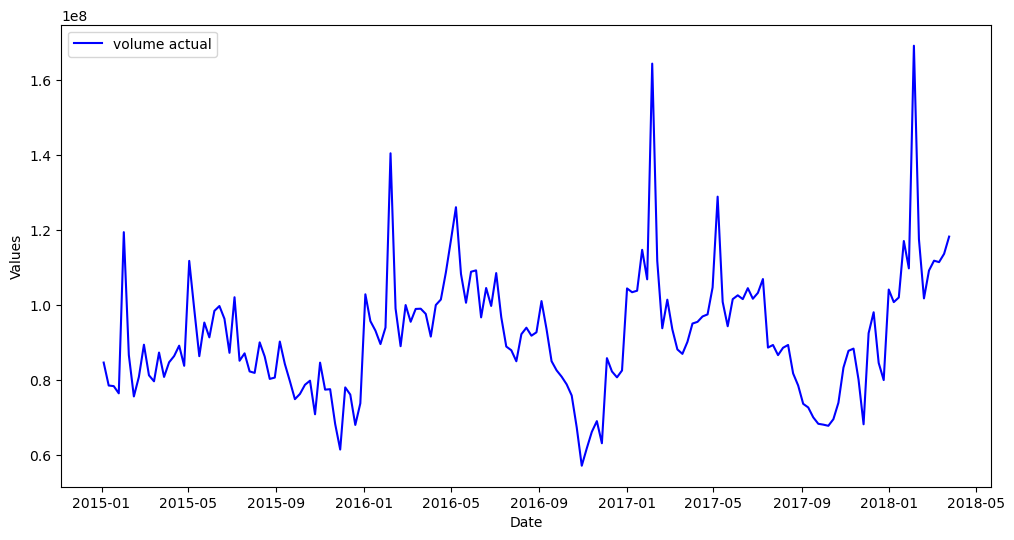

In [47]:
mvf.plot(series='volume')
plt.show()

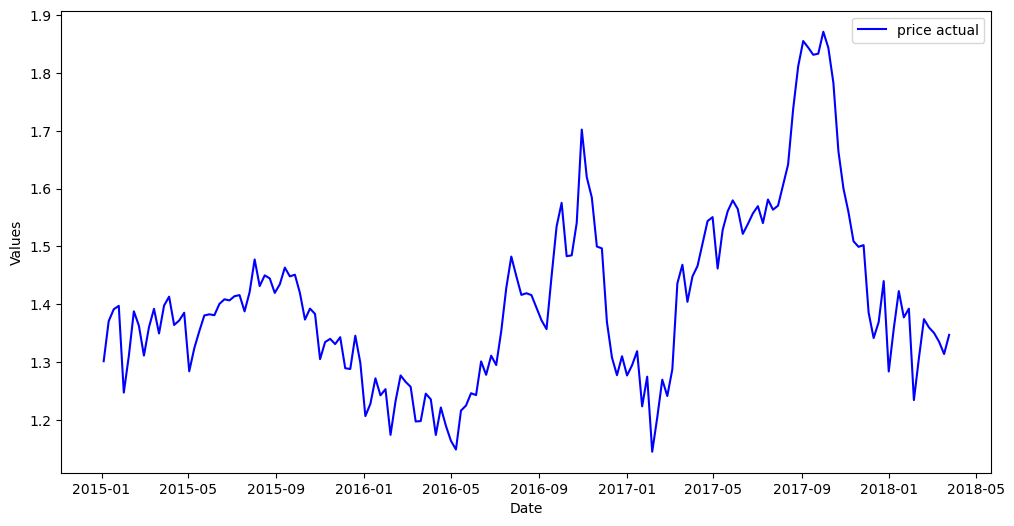

In [48]:
mvf.plot(series='price')
plt.show()

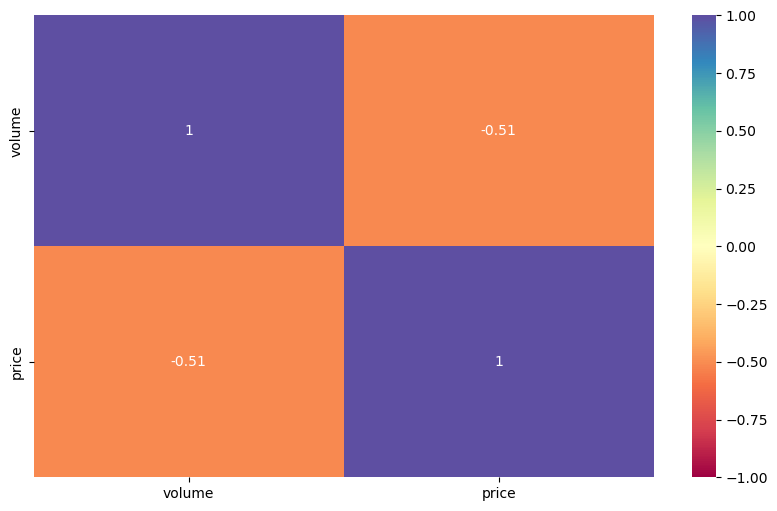

In [49]:
mvf.corr(disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1)
plt.show()

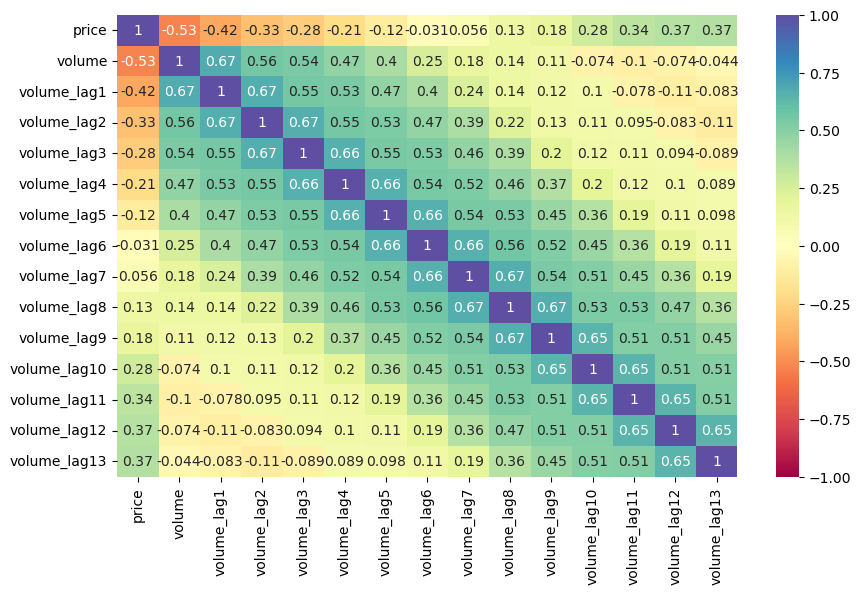

In [50]:
mvf.corr_lags(y='price',x='volume',disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1,lags=13)
plt.show()

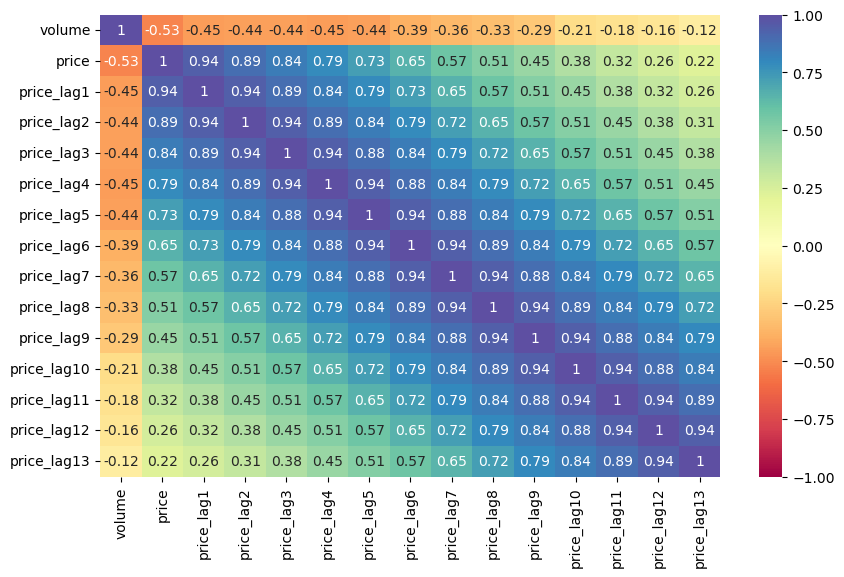

In [51]:
mvf.corr_lags(y='volume',x='price',disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1,lags=13)
plt.show()

### Parameterize the `MVForecaster` Object
- Starting in scalecast version 0.16.0, you can skip model testing by setting a test length of 0.
- In this example, all models will be tested on the last 15% of the observed values in the dataset.
- We will also have model optimization select hyperparemeters based on what predicts the volume series, rather than the price series, or an average of the two (which is the default), best.
- [Custom optimization](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.add_optimizer_func) functions are available.

In [52]:
mvf.set_test_length(.15)
mvf.set_optimize_on('volume') # we care more about predicting volume and price is just used to make those predictions more accurate
# by default, the optimizer uses an average scoring of all series in the MVForecaster object
mvf.eval_cis() # tell object to evaluate cis

mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    OptimizeOn=volume
    GridsFile=MVGrids
)

### Run Models
- Uses scikit-learn models and APIs only.
- See the adapted [VECM model](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#vecm) for this object.

#### ElasticNet

In [53]:
mvf.set_estimator('elasticnet')
mvf.manual_forecast(alpha=0.2,dynamic_testing=13,lags=13)

#### XGBoost

In [54]:
mvf.set_estimator('xgboost')
mvf.manual_forecast(gamma=1,dynamic_testing=13,lags=13)

#### MLP Stack

In [55]:
mvf.export('model_summaries')

,Series,ModelNickname,Estimator,Xvars,HyperParams,Lags,Scaler,Observations,Tuned,CrossValidated,...,LevelTestSetMAPE,LevelInSampleMAPE,TestSetMAE,InSampleMAE,LevelTestSetMAE,LevelInSampleMAE,TestSetR2,InSampleR2,LevelTestSetR2,LevelInSampleR2
0,volume,elasticnet,elasticnet,"[t, weeksin, weekcos]",{'alpha': 0.2},13,minmax,169,None,False,...,0.131497,0.087812,1.379208e+07,8.102285e+06,1.379208e+07,8.102285e+06,0.180973,0.495710,0.180973,0.495710
1,volume,xgboost,xgboost,"[t, weeksin, weekcos]",{'gamma': 1},13,minmax,169,None,False,...,0.116672,0.000003,1.238326e+07,2.591667e+02,1.238326e+07,2.591667e+02,0.324370,1.000000,0.324370,1.000000
2,price,elasticnet,elasticnet,"[t, weeksin, weekcos]",{'alpha': 0.2},13,minmax,169,None,False,...,0.071282,0.084080,1.088633e-01,1.199107e-01,1.088633e-01,1.199107e-01,-0.048569,0.000000,-0.048569,0.000000
3,price,xgboost,xgboost,"[t, weeksin, weekcos]",{'gamma': 1},13,minmax,169,None,False,...,0.057186,0.058215,8.791148e-02,8.255353e-02,8.791148e-02,8.255353e-02,0.245089,0.465533,0.245089,0.465533


In [56]:
mlp_stack(mvf,model_nicknames=['elasticnet','xgboost'],lags=13)

In [57]:
mvf.set_best_model(determine_best_by='TestSetRMSE')

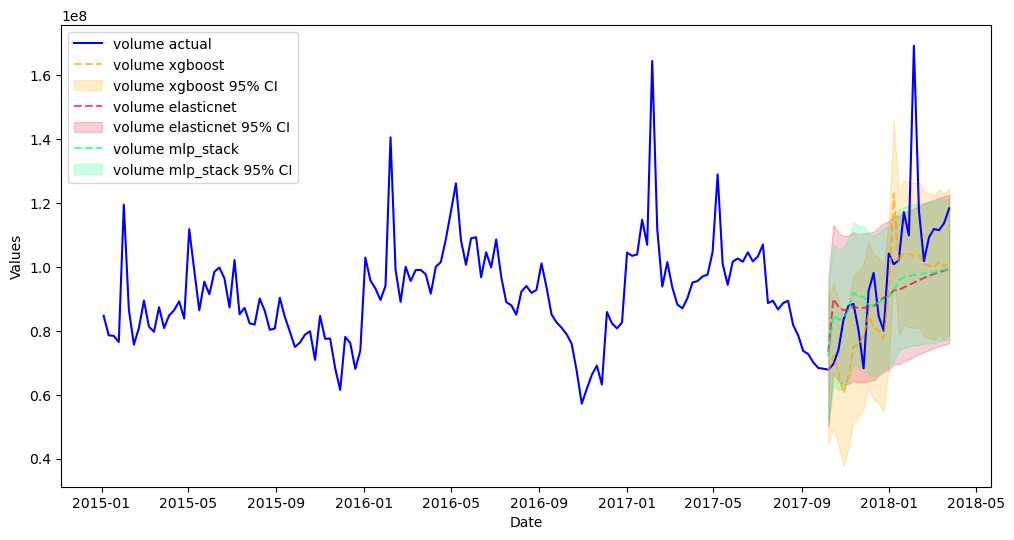

In [58]:
mvf.plot_test_set(ci=True,series='volume',put_best_on_top=True)
plt.show()

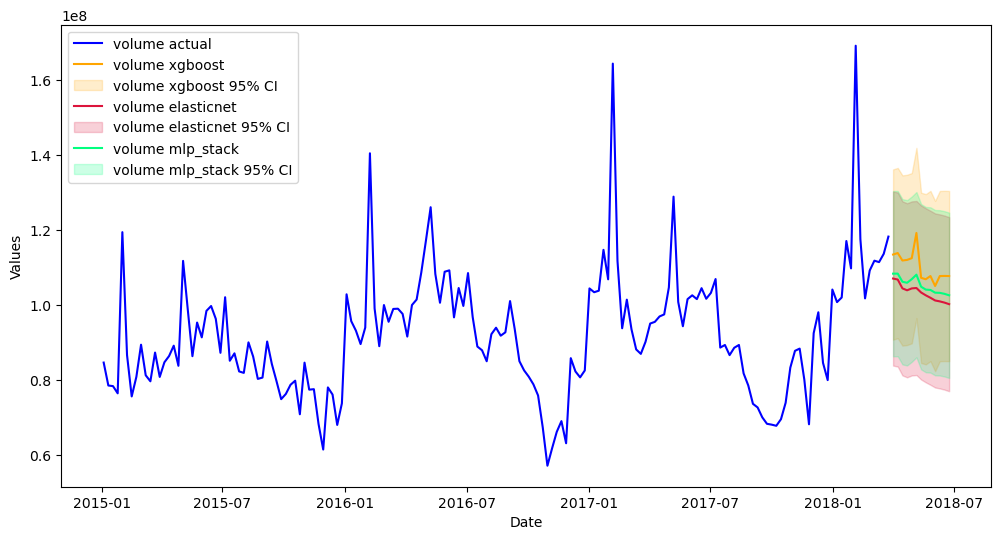

In [59]:
mvf.plot(ci=True,series='volume',put_best_on_top=True)
plt.show()

Probabalistic forecasting for creating confidence intervals is currently being worked on in the MVForecaster object, but until that is done, the backtested interval also works well:

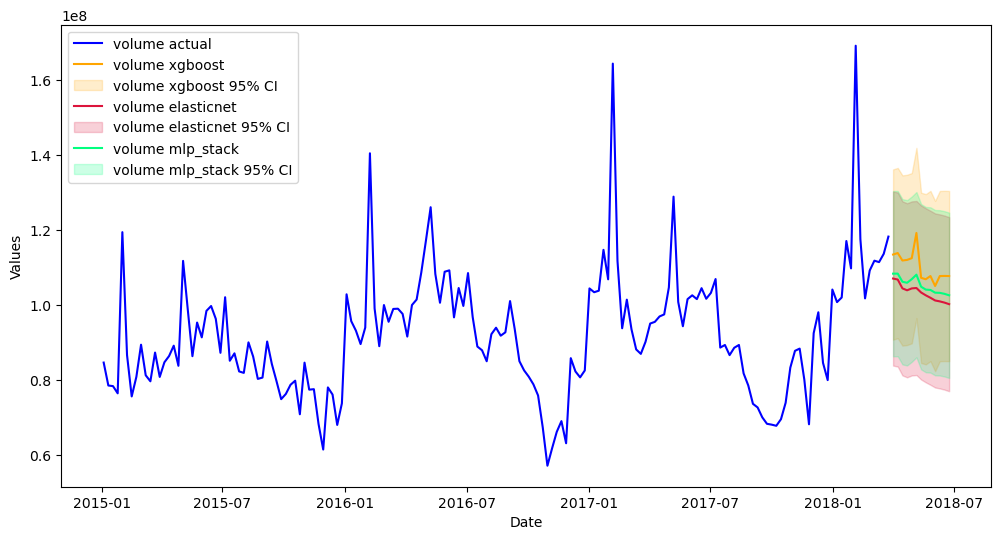

In [60]:
mvf.plot(ci=True,series='volume',put_best_on_top=True)
plt.show()

### Break Back into Forecaster Objects
- You can then add univariate models to these objects to compare with the models run multivariate.

In [61]:
from scalecast.util import break_mv_forecaster

In [62]:
fvol, fprice = break_mv_forecaster(mvf)

In [63]:
fvol

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [64]:
fprice

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

## Transformations
- One of the most effective way to boost forecasting power is with transformations.
- Transformations include:
  - [Log](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.LogTransform)
  - Scaling
    - [Standard](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.ScaleTransform)
    - [MinMax](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.MinMaxTransform)
  - [Differencing](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.DiffTransform)
  - [Detrending](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.DetrendTransform)
  - [Custom Functions](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.Transform)
- All transformations have a corresponding revert function.
- See the [blog post](https://medium.com/towards-data-science/time-series-transformations-and-reverting-made-easy-f4f768c18f63).

In [65]:
from scalecast.SeriesTransformer import SeriesTransformer

In [66]:
f_trans = Forecaster(y=volume,current_dates=volume.index,future_dates=13)

In [67]:
f_trans.set_test_length(.15)
f_trans.set_validation_length(13)

In [68]:
transformer = SeriesTransformer(f_trans)

In [69]:
# these will all be reverted later after forecasts have been called
f_trans = transformer.DiffTransform(1)
f_trans = transformer.DiffTransform(52)
f_trans = transformer.DetrendTransform()

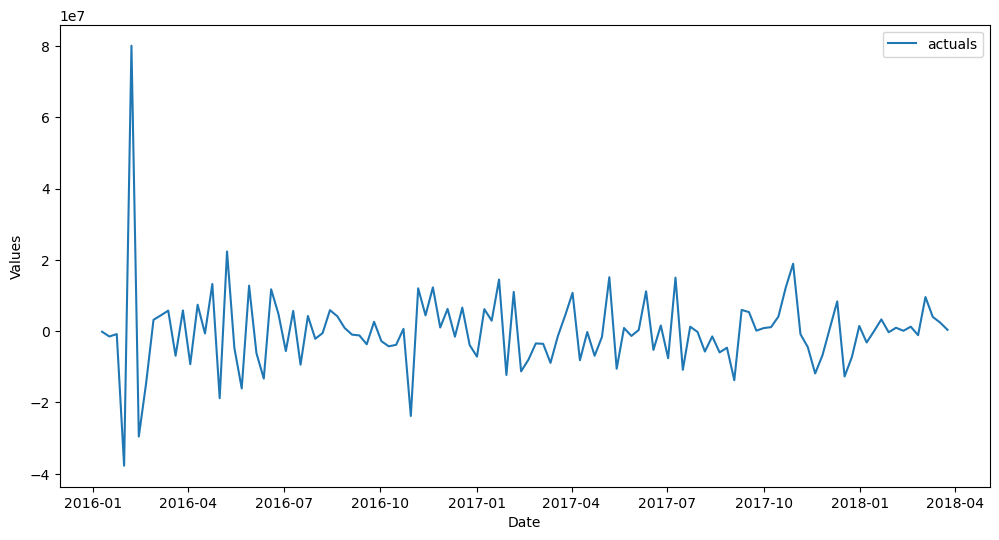

In [70]:
f_trans.plot()
plt.show()

In [71]:
f_trans.add_time_trend()
f_trans.add_seasonal_regressors('week',sincos=True,raw=False)
f_trans.add_ar_terms(13)

In [72]:
f_trans.set_estimator('xgboost')
f_trans.manual_forecast(gamma=1,dynamic_testing=13)

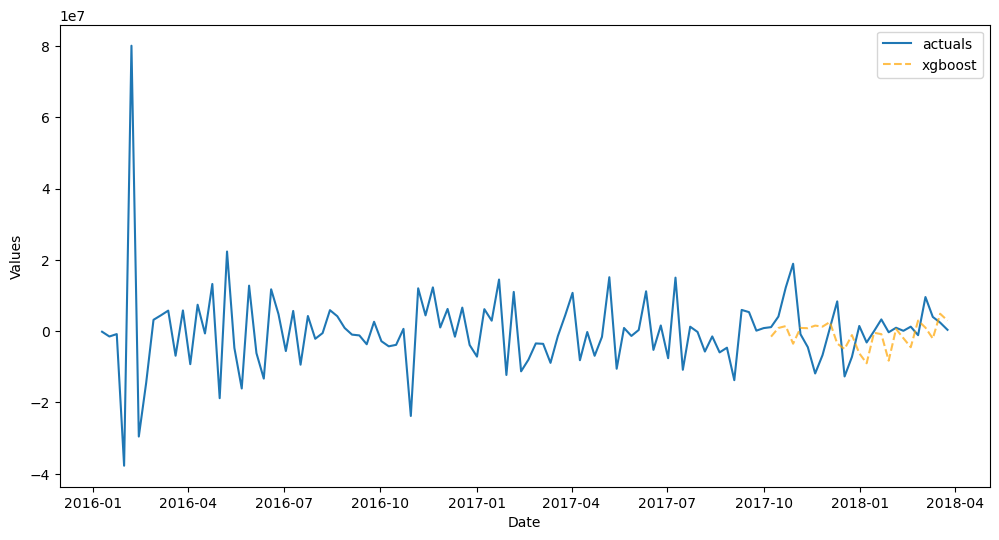

In [73]:
f_trans.plot_test_set()
plt.show()

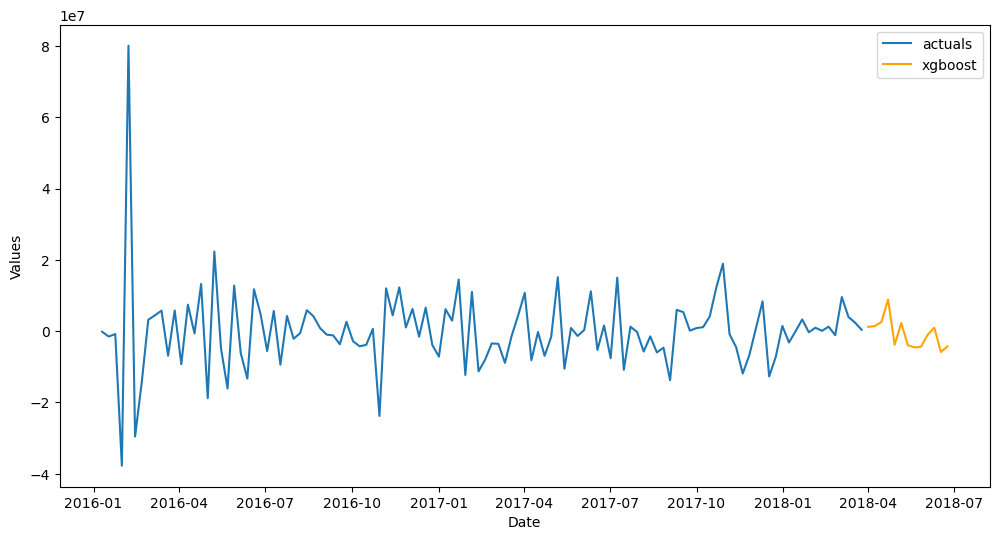

In [74]:
f_trans.plot()
plt.show()

In [75]:
# call revert functions in the opposite order as how they were called when transforming
f_trans = transformer.DetrendRevert()
f_trans = transformer.DiffRevert(52)
f_trans = transformer.DiffRevert(1)

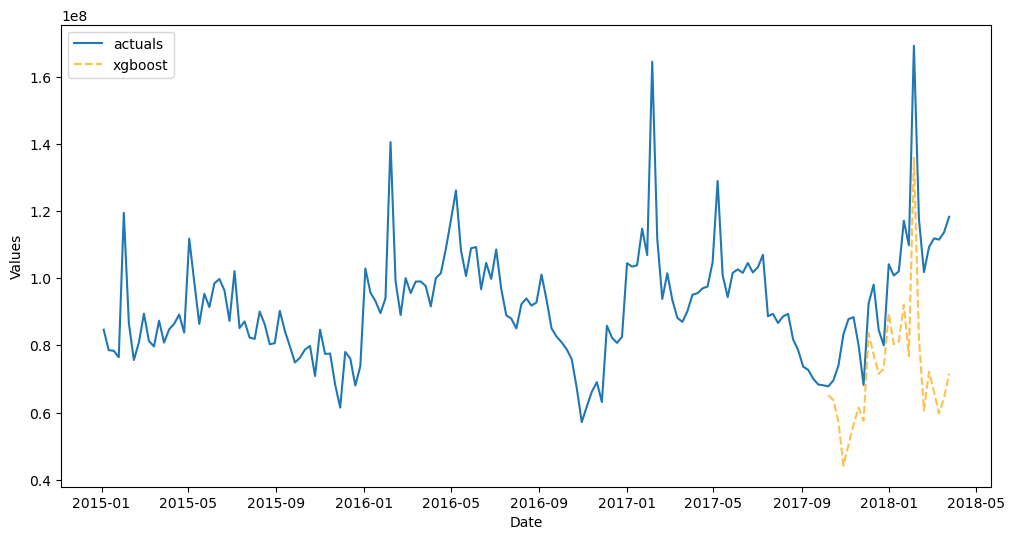

In [76]:
f_trans.plot_test_set()
plt.show()

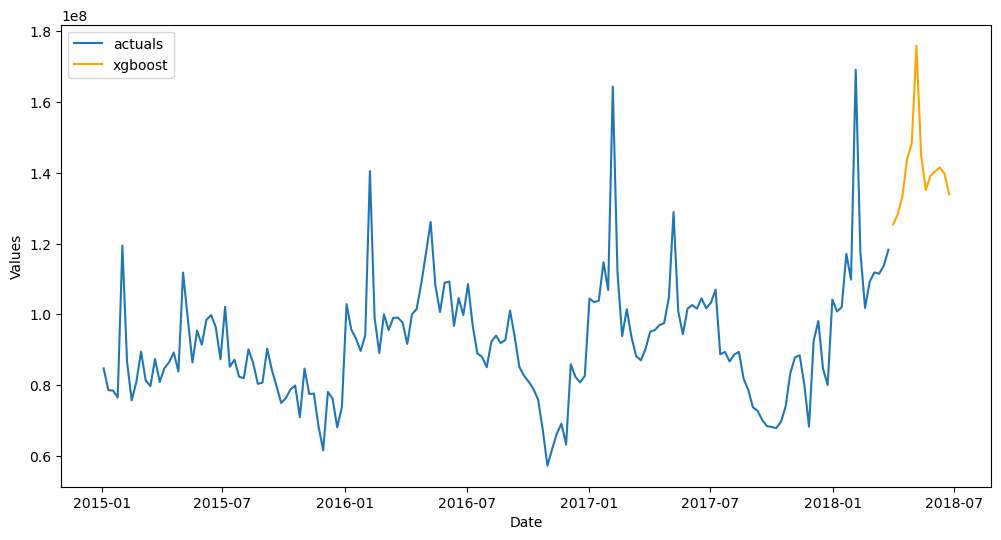

In [77]:
f_trans.plot()
plt.show()

## Pipelines
- These are objects similar to scikit-learn pipelines that offer readable and streamlined code for transforming, forecasting, and reverting.
- See the [Pipeline object documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html).

In [78]:
from scalecast.Pipeline import Transformer, Reverter, Pipeline, MVPipeline

In [79]:
f_pipe = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
f_pipe.set_test_length(.15)

In [80]:
def forecaster(f):
    f.add_time_trend()
    f.add_seasonal_regressors('week',raw=False,sincos=True)
    f.add_ar_terms(13)
    f.set_estimator('lightgbm')
    f.manual_forecast(max_depth=2)

In [81]:
transformer = Transformer(
    transformers = [
        ('DiffTransform',1),
        ('DiffTransform',52),
        ('DetrendTransform',)
    ]
)

reverter = Reverter(
    reverters = [
        ('DetrendRevert',),
        ('DiffRevert',52),
        ('DiffRevert',1)
    ],
    base_transformer = transformer,
)

In [82]:
reverter

Reverter(
  reverters = [
    ('DetrendRevert',),
    ('DiffRevert', 52),
    ('DiffRevert', 1)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DiffTransform', 1),
    ('DiffTransform', 52),
    ('DetrendTransform',)
  ]
)
)

In [83]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f_pipe = pipeline.fit_predict(f_pipe)

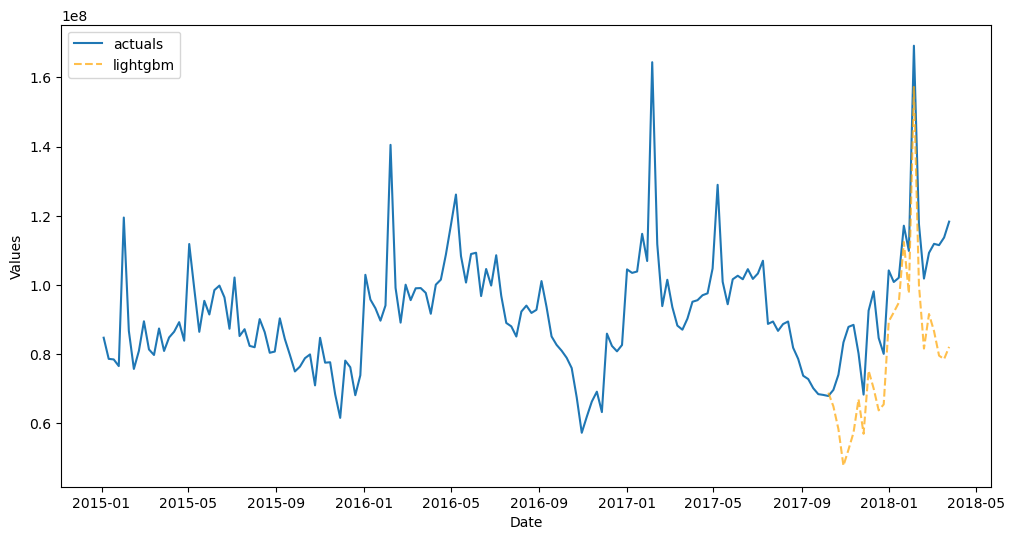

In [84]:
f_pipe.plot_test_set()
plt.show()

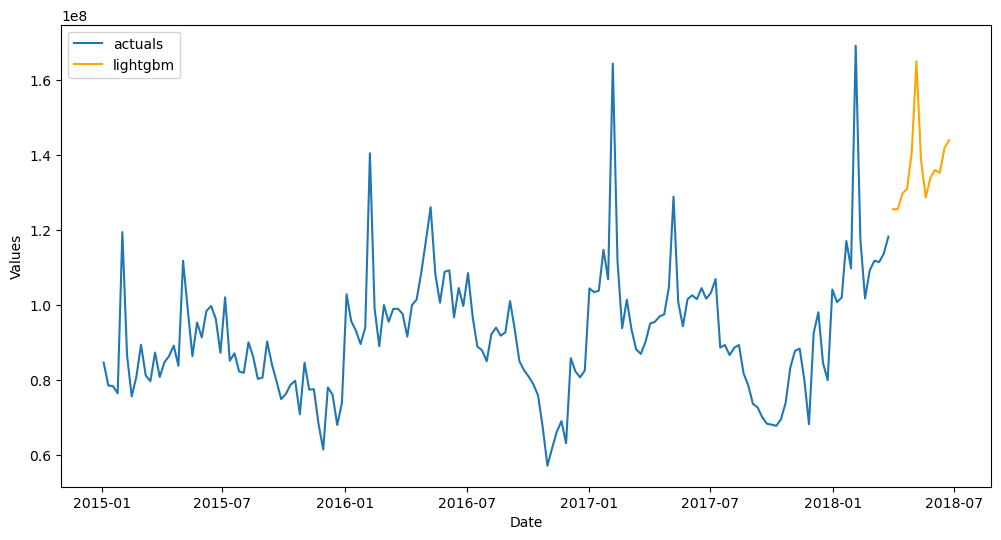

In [85]:
f_pipe.plot()
plt.show()

## Fully Automated Pipelines
- We can automate the construction of pipelines, the selection of input variables, and tuning of models with cross validation on a grid search for each model using files in the working directory called `Grids.py` for univariate forecasting and `MVGrids.py` for multivariate. Default grids can be downloaded from scalecast.

### Automated Univariate Pipelines
- [Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Pipeline)

In [86]:
from scalecast import GridGenerator
from scalecast.util import find_optimal_transformation

In [87]:
GridGenerator.get_example_grids(overwrite=True)

In [88]:
f_pipe_aut = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
f_pipe_aut.set_test_length(.15)

In [89]:
def forecaster_aut(f,models):
    f.auto_Xvar_select(
        estimator='elasticnet',
        monitor='TestSetMAE',
        alpha=0.2,
        irr_cycles = [26],
    )
    f.tune_test_forecast(
        models,
        cross_validate=True,
        k=3,
        # dynamic tuning = 13 means we will hopefully find a model that is optimized to predict 13 steps
        dynamic_tuning=13,
        dynamic_testing=13,
    )
    f.set_estimator('combo')
    f.manual_forecast()

### util.find_optimal_transformation
In this function, the following transformations are searched for:  
- Detrending  
- Box-Cox  
- First Differencing  
- Seasonal Differencing  
- Scaling  

The optimal set of transformations are returned based on best estimated out-of-sample performance on the test set. Therefore, running this function introduces leakage into the test set, but it can still be a good addition to an automated pipeline, depending on the application. Which and the order of transfomations to search through are configurable. How performance is measured, the parameters specific to a given transformation, and several other paramters are also configurable. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#module-src.scalecast.util.find_optimal_transformation).

In [90]:
transformer_aut, reverter_aut = find_optimal_transformation(
    f_pipe_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
) # returns a Transformer and Reverter object that can be plugged into a larger pipeline

In [91]:
# see the set of transformations that were selected for this series
reverter_aut

Reverter(
  reverters = [
    ('DiffRevert', 52),
    ('DeseasonRevert',),
    ('DetrendRevert',)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DetrendTransform', {'poly_order': 1}),
    ('DeseasonTransform', {'m': 52, 'model': 'add'}),
    ('DiffTransform', 52)
  ]
)
)

In [92]:
pipeline_aut = Pipeline(
    steps = [
        ('Transform',transformer_aut),
        ('Forecast',forecaster_aut),
        ('Revert',reverter_aut),
    ]
)

f_pipe_aut = pipeline_aut.fit_predict(
    f_pipe_aut,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
        'knn',
    ],
)

In [93]:
f_pipe_aut

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'AR1', 'AR2']
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['mlr', 'elasticnet', 'xgboost', 'lightgbm', 'knn', 'combo']
    CILevel=None
    CurrentEstimator=combo
    GridsFile=Grids
)

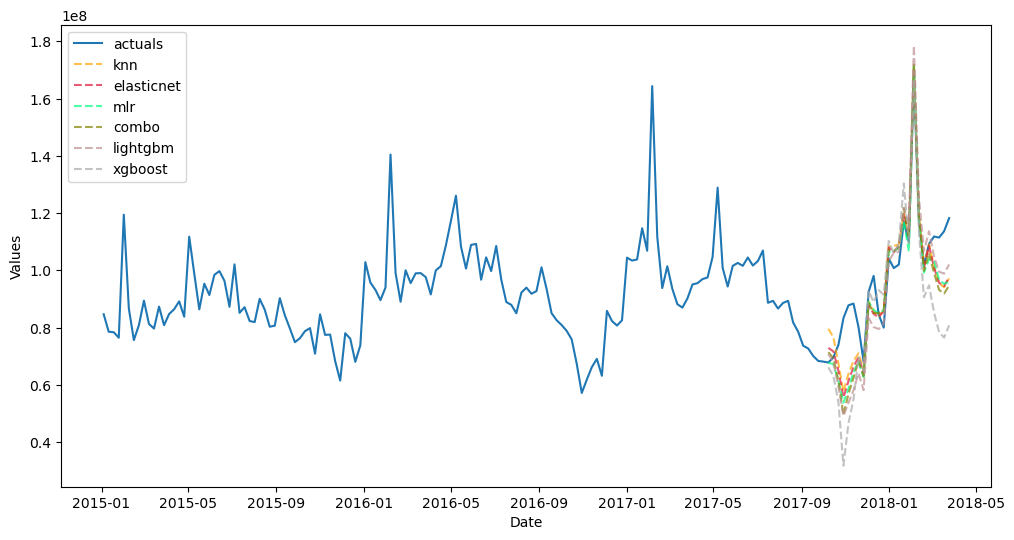

In [94]:
f_pipe_aut.plot_test_set(order_by='TestSetRMSE')
plt.show()

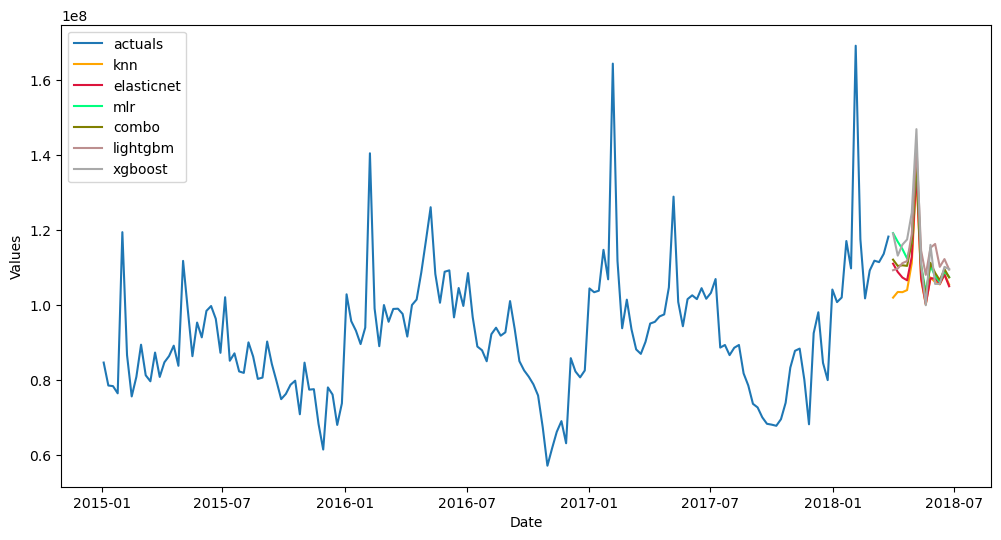

In [95]:
f_pipe_aut.plot(order_by='TestSetRMSE')
plt.show()

### Backtest Univariate Pipeline

You may be interested to know beyond a single test-set metric, how well your pipeline performs out-of-sample. Backtesting can help answer that by iterating through the entire pipeline several times and testing the procedure each time. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Pipeline.backtest).

In [96]:
from scalecast.util import backtest_metrics

In [97]:
uv_backtest_results = pipeline_aut.backtest(
    f_pipe_aut,
    n_iter = 3,
    jump_back = 13,
    cis = False,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
        'knn',
    ],
)

/Users/uger7/Documents/GitHub/scalecast/src/scalecast/Forecaster.py:3819: Warning:

None of the keyword/value combos stored in the grid could be evaluated for the mlr model. See the errors in warnings.log.

/Users/uger7/Documents/GitHub/scalecast/src/scalecast/Forecaster.py:3819: Warning:

None of the keyword/value combos stored in the grid could be evaluated for the elasticnet model. See the errors in warnings.log.

/Users/uger7/Documents/GitHub/scalecast/src/scalecast/Forecaster.py:3819: Warning:

None of the keyword/value combos stored in the grid could be evaluated for the xgboost model. See the errors in warnings.log.

/Users/uger7/Documents/GitHub/scalecast/src/scalecast/Forecaster.py:3819: Warning:

None of the keyword/value combos stored in the grid could be evaluated for the lightgbm model. See the errors in warnings.log.

/Users/uger7/Documents/GitHub/scalecast/src/scalecast/Forecaster.py:3819: Warning:

None of the keyword/value combos stored in the grid could be evaluated f

After obtaining the results from the backtest, we can see the average performance over each iteration using the `util.backtest_metrics` function. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#module-src.scalecast.util.backtest_metrics).

In [98]:
pd.options.display.float_format = '{:,.4f}'.format
backtest_metrics(
    uv_backtest_results,
    mets=['mape','smape','mae','rmse'],
)

Iter0           Iter1           Iter2  \
Model      Metric                                                   
mlr        mape            0.1332          0.2279          0.1493   
           smape           0.1468          0.2716          0.1348   
           mae    15,396,443.8119 19,075,493.8851 11,733,716.3944   
           rmse   18,302,921.9748 22,765,819.4697 13,845,520.4073   
elasticnet mape            0.0824          0.2156          0.1574   
           smape           0.0890          0.2550          0.1414   
           mae     9,401,801.3099 18,064,255.2048 12,352,033.9478   
           rmse   12,642,844.6604 21,712,166.9426 14,517,690.8423   
xgboost    mape            0.1376          0.2202          0.1311   
           smape           0.1532          0.2664          0.1198   
           mae    15,730,229.4112 18,273,511.3700 10,314,460.5971   
           rmse   18,888,800.8744 22,837,915.7588 12,353,556.1074   
lightgbm   mape            0.1566          0.1363          0.1785   
           smape           0.1724          0.1424          0.1578   
           mae    17,729,067.9305 10,951,150.9351 13,904,400.1204   
           rmse   19,009,754.0441 13,259,622.6999 16,481,532.0961   
knn        mape            0.1276          0.1463          0.1839   
           smape           0.1402          0.1597          0.1647   
           mae    14,550,048.8843 12,034,975.2517 14,652,810.9701   
           rmse   17,290,585.5507 14,537,824.5473 16,197,909.0837   
combo      mape            0.1220          0.1784          0.1598   
           smape           0.1319          0.2055          0.1438   
           mae    13,982,229.7832 14,901,972.2746 12,572,247.2018   
           rmse   15,478,386.8021 18,447,732.8046 14,573,740.6263   

                          Average  
Model      Metric                  
mlr        mape            0.1701  
           smape           0.1844  
           mae    15,401,884.6972  
           rmse   18,304,753.9506  
elasticnet mape            0.1518  
           smape           0.1618  
           mae    13,272,696.8208  
           rmse   16,290,900.8151  
xgboost    mape            0.1630  
           smape           0.1798  
           mae    14,772,733.7928  
           rmse   18,026,757.5802  
lightgbm   mape            0.1572  
           smape           0.1575  
           mae    14,194,872.9954  
           rmse   16,250,302.9467  
knn        mape            0.1526  
           smape           0.1549  
           mae    13,745,945.0354  
           rmse   16,008,773.0606  
combo      mape            0.1534  
           smape           0.1604  
           mae    13,818,816.4199  
           rmse   16,166,620.0776

### Automated Multivariate Pipelines
- See the [MVPipeline object documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.MVPipeline).

In [99]:
GridGenerator.get_mv_grids(overwrite=True)

In [100]:
fvol_aut = Forecaster(
    y=volume,
    current_dates=volume.index,
    future_dates=13,
    test_length = .15,
)
fprice_aut = Forecaster(
    y=price,
    current_dates=price.index,
    future_dates=13,
    test_length = .15,
)

In [101]:
def add_vars(f,**kwargs):
    f.add_seasonal_regressors(
        'month',
        'quarter',
        'week',
        raw=False,
        sincos=True
    )

def mvforecaster(mvf,models):
    mvf.set_optimize_on('volume')
    mvf.tune_test_forecast(
        models,
        cross_validate=True,
        k=2,
        rolling=True,
        dynamic_tuning=13,
        dynamic_testing=13,
        limit_grid_size = .2,
        error = 'warn',
    )

In [102]:
transformer_vol, reverter_vol = find_optimal_transformation(
    fvol_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
)

In [103]:
# see the set of transformations that were selected for this series
reverter_vol

Reverter(
  reverters = [
    ('DiffRevert', 52),
    ('DeseasonRevert',),
    ('DetrendRevert',)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DetrendTransform', {'poly_order': 1}),
    ('DeseasonTransform', {'m': 52, 'model': 'add'}),
    ('DiffTransform', 52)
  ]
)
)

In [104]:
transformer_price, reverter_price = find_optimal_transformation(
    fprice_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
)

In [105]:
# see the set of transformations that were selected for this series
reverter_price

Reverter(
  reverters = [
    ('ScaleRevert',),
    ('DeseasonRevert',)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DeseasonTransform', {'m': 52, 'model': 'add'}),
    ('ScaleTransform',)
  ]
)
)

In [106]:
mvpipeline = MVPipeline(
    steps = [
        ('Transform',[transformer_vol,transformer_price]),
        ('Add Xvars',[add_vars]*2),
        ('Forecast',mvforecaster),
        ('Revert',[reverter_vol,reverter_price]),
    ],
    test_length = 20,
    cis = True,
    names = ['volume','price'],
)

fvol_aut, fprice_aut = mvpipeline.fit_predict(
    fvol_aut, 
    fprice_aut,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
    ],
) # returns a tuple of Forecaster objects

Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations


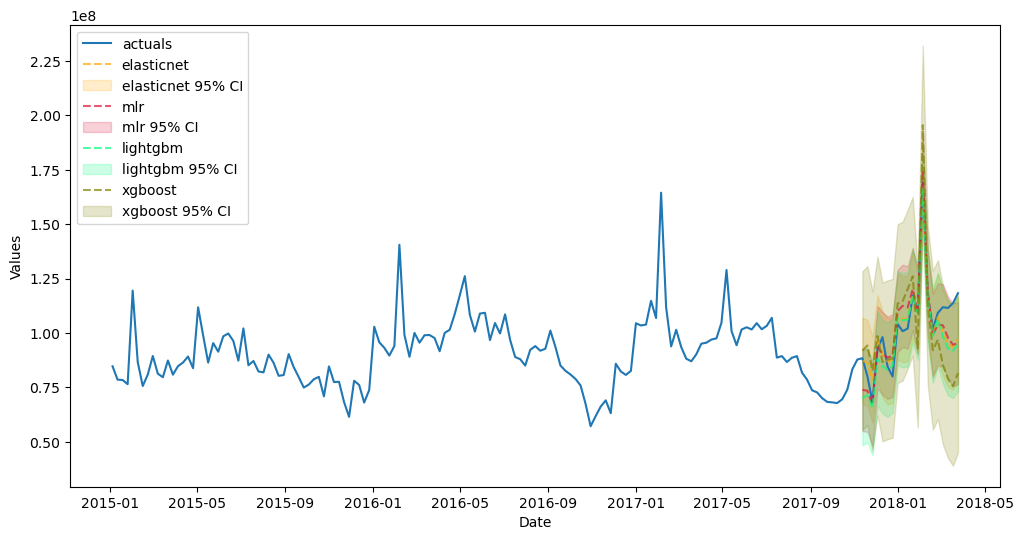

In [107]:
fvol_aut.plot_test_set(order_by='TestSetRMSE',ci=True)
plt.show()

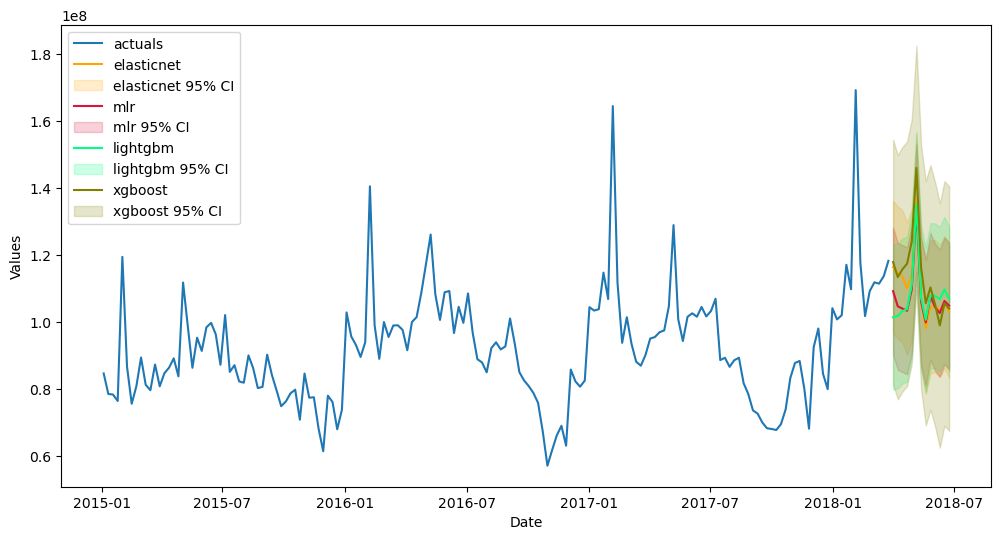

In [108]:
fvol_aut.plot(order_by='TestSetRMSE',ci=True)
plt.show()

### Backtest Multivariate Pipeline

Like univariate pipelines, multivariate pipelines can also be backtested. Info about each model and series becomes possible to compare. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.MVPipeline.backtest).

In [109]:
# recreate Forecaster objects to bring dates back lost from taking seasonal differences
fvol_aut = Forecaster(
    y=volume,
    current_dates=volume.index,
    future_dates=13,
)
fprice_aut = Forecaster(
    y=price,
    current_dates=price.index,
    future_dates=13,
)

In [110]:
mv_backtest_results = mvpipeline.backtest(
    fvol_aut, 
    fprice_aut,
    n_iter = 3,
    jump_back = 13,
    test_length = 0,
    cis = False,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
    ],
)

Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations


In [111]:
backtest_metrics(
    mv_backtest_results,
    mets=['smape','rmse'],
    names = ['Volume','Price'],
)

Iter0           Iter1           Iter2  \
Series Model      Metric                                                   
Volume mlr        smape           0.0715          0.2641          0.1191   
                  rmse   10,306,274.9497 22,062,896.0890 11,289,847.0483   
       elasticnet smape           0.0736          0.2090          0.1487   
                  rmse   11,395,931.0350 19,145,647.4197 15,749,496.8672   
       xgboost    smape           0.0836          0.2124          0.0759   
                  rmse   11,522,489.6536 21,520,451.7021  7,636,195.2102   
       lightgbm   smape           0.1020          0.1981          0.1602   
                  rmse   12,385,757.4633 18,050,447.9340 16,710,877.1931   
Price  mlr        smape           0.0680          0.0922          0.0646   
                  rmse            0.1010          0.1585          0.1419   
       elasticnet smape           0.0284          0.0806          0.1490   
                  rmse            0.0458          0.1366          0.2679   
       xgboost    smape           0.0750          0.0786          0.0872   
                  rmse            0.1117          0.1406          0.1833   
       lightgbm   smape           0.1121          0.0714          0.1612   
                  rmse            0.1621          0.1263          0.2815   

                                 Average  
Series Model      Metric                  
Volume mlr        smape           0.1516  
                  rmse   14,553,006.0290  
       elasticnet smape           0.1438  
                  rmse   15,430,358.4406  
       xgboost    smape           0.1240  
                  rmse   13,559,712.1886  
       lightgbm   smape           0.1534  
                  rmse   15,715,694.1968  
Price  mlr        smape           0.0749  
                  rmse            0.1338  
       elasticnet smape           0.0860  
                  rmse            0.1501  
       xgboost    smape           0.0803  
                  rmse            0.1452  
       lightgbm   smape           0.1149  
                  rmse            0.1900

Through backtesting, we can see that the multivariate approach out-performed the univariate approach. Very cool!

## Scaled Automated Forecasting
- We can scale the fully automated approach to many series where we can then access all results through plotting with Jupyter widgets and export functions.
- We produce a separate forecast for avocado sales in each region in our dataset.
- This is done with a univariate approach, but cleverly using the code in this notebook, it could be transformed into a multivariate process where volume and price are forecasted together.

In [112]:
from scalecast.notebook import results_vis
from tqdm.notebook import tqdm

In [113]:
def forecaster_scaled(f,models):
    f.auto_Xvar_select(
        estimator='elasticnet',
        monitor='TestSetMAE',
        alpha=0.2,
        irr_cycles = [26],
    )
    f.tune_test_forecast(
        models,
        dynamic_testing=13,
    )
    f.set_estimator('combo')
    f.manual_forecast()

In [114]:
results_dict = {}
for region in tqdm(data.region.unique()):
    series = data.loc[data['region'] == region].groupby('Date')['Total Volume'].sum()
    f_i = Forecaster(
        y = series,
        current_dates = series.index,
        future_dates = 13,
        test_length = .15,
        validation_length = 13,
        cis = True,
    )
    transformer_i, reverter_i = find_optimal_transformation(
        f_i,
        lags = 13,
        m = 52,
        monitor = 'mae',
        estimator = 'elasticnet',
        alpha = 0.2,
        test_length = 13,
    )
    pipeline_i = Pipeline(
        steps = [
            ('Transform',transformer_i),
            ('Forecast',forecaster_scaled),
            ('Revert',reverter_i),
        ]
    )
    f_i = pipeline_i.fit_predict(
        f_i,
        models=[
            'mlr',
            'elasticnet',
            'xgboost',
            'lightgbm',
            'knn',
        ],
    )
    results_dict[region] = f_i

  0%|          | 0/54 [00:00<?, ?it/s]

Run the next two functions locally to see the full functionality of these widgets.

In [115]:
results_vis(results_dict,'test')

Dropdown(description='Time Series:', options=('Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', '…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6), value=1)

Dropdown(description='View Level', options=(False, True), value=False)

Dropdown(description='View Confidence Intervals', options=(False, True), value=False)

Dropdown(description='Order By', index=15, options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE…

Button(description='Select Time Series', style=ButtonStyle())

Output()

In [116]:
results_vis(results_dict)

Dropdown(description='Time Series:', options=('Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', '…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6), value=1)

Dropdown(description='View Level', options=(False, True), value=False)

Dropdown(description='View Confidence Intervals', options=(False, True), value=False)

Dropdown(description='Order By', index=15, options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE…

Button(description='Select Time Series', style=ButtonStyle())

Output()

## Exporting Results

In [117]:
from scalecast.multiseries import export_model_summaries

### Exporting Results from a Single `Forecaster` Object

In [118]:
results = f.export(cis=True)
results.keys()

dict_keys(['model_summaries', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [119]:
for k, df in results.items():
    print(f'{k} has these columns : {df.columns}')

model_summaries has these columns : Index(['ModelNickname', 'Estimator', 'Xvars', 'HyperParams', 'Scaler',
       'Observations', 'Tuned', 'CrossValidated', 'DynamicallyTested',
       'Integration', 'TestSetLength', 'CILevel', 'ValidationSetLength',
       'ValidationMetric', 'ValidationMetricValue', 'models', 'weights',
       'best_model', 'TestSetRMSE', 'InSampleRMSE', 'TestSetMAPE',
       'InSampleMAPE', 'TestSetMAE', 'InSampleMAE', 'TestSetR2', 'InSampleR2',
       'LevelTestSetRMSE', 'LevelInSampleRMSE', 'LevelTestSetMAPE',
       'LevelInSampleMAPE', 'LevelTestSetMAE', 'LevelInSampleMAE',
       'LevelTestSetR2', 'LevelInSampleR2'],
      dtype='object')
lvl_fcsts has these columns : Index(['DATE', 'mlr', 'mlr_upperci', 'mlr_lowerci', 'lasso', 'lasso_upperci',
       'lasso_lowerci', 'ridge', 'ridge_upperci', 'ridge_lowerci',
       'elasticnet', 'elasticnet_upperci', 'elasticnet_lowerci', 'sgd',
       'sgd_upperci', 'sgd_lowerci', 'rf', 'rf_upperci', 'rf_lowerci', 'gbt',
   

In [120]:
results['model_summaries'][['ModelNickname','HyperParams','TestSetMAPE','InSampleMAPE']]

,ModelNickname,HyperParams,TestSetMAPE,InSampleMAPE
0,mlr,{},0.0992,0.0758
1,lasso,{'alpha': 0.2},0.0992,0.0758
2,ridge,{'alpha': 0.2},0.1001,0.0757
3,elasticnet,"{'alpha': 0.2, 'l1_ratio': 0.5}",0.1270,0.0914
4,sgd,"{'alpha': 0.2, 'l1_ratio': 0.5}",0.1226,0.0928
5,rf,{'max_depth': 2},0.1292,0.0682
6,gbt,{'max_depth': 2},0.1321,0.0321
7,xgboost,{'gamma': 1},0.1371,0.0000
8,lightgbm,{'max_depth': 2},0.1216,0.0455
9,catboost,"{'depth': 4, 'verbose': False}",0.1136,0.0095


Other export functions:  
[Forecaster.export_Xvars_df](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_Xvars_df)  
[Forecaster.export_backtest_metrics](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_backtest_metrics)  
[Forecaster.export_backtest_values](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_backtest_values)
[Forecaster.export_feature_importance](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_feature_importance)  
[Forecaster.export_fitted_vals](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_fitted_vals)  
[Forecaster.export_summary_stats](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_summary_stats)  
[Forecaster.export_validation_grid](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_validation_grid)  

Other plotting functions:  
[Forecaster.plot_fitted](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.plot_fitted)  
[Forecaster.plot_periodogram](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.plot_periodogram)  

### Exporting Results from a Single `MVForecaster` Object

In [121]:
mvresults = mvf.export(cis=True)
mvresults.keys()

dict_keys(['model_summaries', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [122]:
for k, df in mvresults.items():
    print(f'{k} has these columns : {df.columns}')

model_summaries has these columns : Index(['Series', 'ModelNickname', 'Estimator', 'Xvars', 'HyperParams', 'Lags',
       'Scaler', 'Observations', 'Tuned', 'CrossValidated',
       'DynamicallyTested', 'Integration', 'TestSetLength',
       'ValidationSetLength', 'ValidationMetric', 'ValidationMetricValue',
       'OptimizedOn', 'MetricOptimized', 'best_model', 'TestSetRMSE',
       'InSampleRMSE', 'LevelTestSetRMSE', 'LevelInSampleRMSE', 'TestSetMAPE',
       'InSampleMAPE', 'LevelTestSetMAPE', 'LevelInSampleMAPE', 'TestSetMAE',
       'InSampleMAE', 'LevelTestSetMAE', 'LevelInSampleMAE', 'TestSetR2',
       'InSampleR2', 'LevelTestSetR2', 'LevelInSampleR2'],
      dtype='object')
lvl_fcsts has these columns : Index(['DATE', 'volume_xgboost_lvl_fcst', 'volume_xgboost_lvl_fcst_upper',
       'volume_xgboost_lvl_fcst_lower', 'volume_elasticnet_lvl_fcst',
       'volume_elasticnet_lvl_fcst_upper', 'volume_elasticnet_lvl_fcst_lower',
       'volume_mlp_stack_lvl_fcst', 'volume_mlp_stack_

In [123]:
mvresults['model_summaries'][['Series','ModelNickname','HyperParams','Lags','TestSetMAE','InSampleMAE']]

,Series,ModelNickname,HyperParams,Lags,TestSetMAE,InSampleMAE
0,volume,xgboost,{'gamma': 1},13,"12,383,262.5132",259.1667
1,volume,elasticnet,{'alpha': 0.2},13,"13,792,076.6109","8,102,284.9504"
2,volume,mlp_stack,"{'estimators': [('elasticnet', ElasticNet(alph...",13,"12,965,977.7030","6,501,981.4298"
3,price,xgboost,{'gamma': 1},13,0.0879,0.0826
4,price,elasticnet,{'alpha': 0.2},13,0.1089,0.1199
5,price,mlp_stack,"{'estimators': [('elasticnet', ElasticNet(alph...",13,0.1106,0.1010


Other export functions:  
[MVForecaster.export_backtest_metrics](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_backtest_metrics)  
[MVForecaster.export_backtest_values](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_backtest_values)  
[Forecaster.export_fitted_vals](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_fitted_vals)   
[Forecaster.export_validation_grid](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_validation_grid)  

Other plotting functions:  
[MVForecaster.plot_fitted](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.plot_fitted)  

### Exporting Results from a Dictionary of `Forecaster` Objects

In [124]:
all_results = export_model_summaries(results_dict)
all_results[['ModelNickname','Series','Xvars','HyperParams','TestSetMAPE','InSampleMAPE']].sample(10)

,ModelNickname,Series,Xvars,HyperParams,TestSetMAPE,InSampleMAPE
18,mlr,Boise,"[t, AR1, AR2, AR3, AR4, AR5, AR6, AR7, AR8, AR...",{},0.2097,0.0832
126,mlr,LasVegas,"[t, AR1, AR2, AR3, AR4, AR5, AR6, AR7, AR8, AR...",{},0.0872,0.0710
232,knn,RichmondNorfolk,"[weeksin, weekcos, monthsin, monthcos, quarter...",{'n_neighbors': 46},0.1211,0.1222
84,mlr,GrandRapids,"[cycle26sin, cycle26cos]",{},0.2102,0.3116
161,combo,Nashville,None,{},0.1239,0.1662
63,lightgbm,Columbus,"[t, AR1, AR2, AR3, AR4, AR5, AR6, AR7, AR8, AR...","{'n_estimators': 250, 'boosting_type': 'dart',...",0.1721,0.1880
136,knn,LosAngeles,"[weeksin, weekcos, monthsin, monthcos, quarter...",{'n_neighbors': 2},0.1719,0.0627
51,lightgbm,Chicago,"[weeksin, weekcos, AR1, AR2, AR3, AR4, AR5, cy...","{'n_estimators': 250, 'boosting_type': 'dart',...",0.1325,0.1287
108,mlr,Houston,"[lnt, weeksin, weekcos, monthsin, monthcos, AR...",{},0.1240,0.1417
199,elasticnet,PhoenixTucson,"[cycle26sin, cycle26cos]","{'alpha': 0.1, 'l1_ratio': 0.25}",0.1494,0.1809
